In [3]:
import os
from PIL import Image
import glob
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data
from torchvision import datasets, transforms

# Data preparation


1.   get path
2.   dataloader for img and mask
1.   split into test and validation





In [4]:
import os
from PIL import Image
import glob
import matplotlib.pyplot as plt

#define dataset for img and mask
file_dir = "./ISIC2018_Task1-2_Training_Data"
os.chdir(file_dir)

In [5]:
#path
img_path = './ISIC2018_Task1-2_Training_Input_x2'
mask_path = './ISIC2018_Task1_Training_GroundTruth_x2'
imgs = [file for file in sorted(os.listdir(img_path)) if file.endswith('.jpg')]
masks = [file for file in sorted(os.listdir(mask_path)) if file.endswith('.png')]

In [6]:
from torchvision import datasets
from torchvision.datasets import  ImageFolder
from torch.utils.data import dataloader, random_split, Subset
from torchvision.transforms import transforms

In [7]:
from torch.utils.data import Dataset
from PIL import Image

class Unet_dataset(Dataset):
  def __init__(self,
               img_dir = './ISIC2018_Task1-2_Training_Input_x2',
               mask_dir = './ISIC2018_Task1_Training_GroundTruth_x2', 
               img_transforms=None,
               mask_transforms= None):
    
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.img_transforms = img_transforms
    self.mask_transforms = mask_transforms

    self.imgs = [file for file in sorted(os.listdir(self.img_dir)) if file.endswith('.jpg')]
    self.masks = [file for file in sorted(os.listdir(self.mask_dir)) if file.endswith('.png')]

  #meke dataloader
  def load_data(self, idx):
    img_path = os.path.join(self.img_dir, self.imgs[idx])
    mask_path = os.path.join(self.mask_dir, self.masks[idx])
    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')
    return img, mask

  def __getitem__(self, idx):
    img, mask = self.load_data(idx)
    #transformation
    if self.img_transforms is not None:
      img = self.img_transforms(img)
    if self.mask_transforms is not None:
      mask = self.mask_transforms(mask)
    return img, mask

  def __len__(self):
    return len(self.imgs)

In [8]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


#transformation
img_tfs = transforms.Compose([
                                 transforms.Resize((128,128)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
                                 ]
                                )

mask_tfs = transforms.Compose([
                                 transforms.Resize((128,128)),
                                 transforms.ToTensor(),
                                 ]
                                )

dataset = Unet_dataset(img_transforms=img_tfs, mask_transforms=mask_tfs)


#shuffle index
sample_size = len(dataset.imgs)
train_size = int(sample_size*0.8)
test_size = sample_size - train_size

#train and test set
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(123))

#dataloader
train_loader= DataLoader(train_set, batch_size=64, shuffle = True)
test_loader= DataLoader(test_set, batch_size=64, shuffle=False)

# Unet

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Context(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Context, self).__init__()
    self.context = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.Dropout2d(p=0.3),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride = 1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            )

  def forward(self, x):
    x = self.context(x) + x
    return x


class Localization(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Localization, self).__init__()
    self.localization = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            )
    
  def forward(self, x):
    return self.localization(x)


class Upsampling(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Upsampling, self).__init__()
    self.upsampling = nn.Sequential(
                            nn.Upsample(scale_factor=2, mode='nearest'),
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            )
    
  def forward(self, x):
    return self.upsampling(x)


class Segment(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Segment, self).__init__()
    self.segment = nn.Sequential(
                              nn.Conv2d(in_channels, out_channels=1, kernel_size=1, stride=1, padding=0, bias=False),
                              nn.BatchNorm2d(out_channels),
                              nn.LeakyReLU(negative_slope=0.02, inplace=True)
                              )
    
  def forward(self, x):
    return self.segment(x)


class Conv2(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Conv2, self).__init__()
    self.conv2 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(negative_slope=0.02, inplace=True),
                            )

  def forward(self, x):
    return self.conv2(x)


class ImprovedUnet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, feature_size=[16, 32, 64, 128]):
    super(ImprovedUnet, self).__init__()
    self.Conv1 = nn.Conv2d(in_channels=3, out_channels=feature_size[0], kernel_size=3, stride=1, padding=1, bias=False)                 
    self.Downs = nn.ModuleList()
    self.Convs = nn.ModuleList()
    self.Ups = nn.ModuleList()
    self.Segmentations = nn.ModuleList()

    self.upscale = nn.Upsample(scale_factor=2, mode='nearest')
    self.bottleneck = Context(feature_size[-1]*2, feature_size[-1]*2)


    #Downsampling frame
    for feature in feature_size:
      self.Downs.append(Context(feature, feature))
      self.Convs.append(Conv2(feature, feature*2))

    #Upsampleing frame
    for feature in reversed(feature_size):
      #Upsample
      self.Ups.append(Upsampling(feature*2, feature))

      #Localization
      if feature != feature_size[0]:
        self.Ups.append(Localization(feature*2,  feature))
      else:
        self.Ups.append(Localization(feature*2,  feature*2))
            
      #Segmentation
      self.Segmentations.append(Segment(feature, 1))

    self.final_conv = nn.Conv2d(feature_size[0]*2, out_channels, kernel_size=1, stride=1, bias=False)
                      

  def forward(self, x):
    skip_connections = []
    segmentation_layers = []

    x = self.Conv1(x)

    #Downsampling steps
    for i, (context_i, conv_i) in enumerate(zip(self.Downs, self.Convs)):
      x = context_i(x)
      #preserve location
      skip_connections.append(x)
      x = conv_i(x)

    x = self.bottleneck(x) + x
    skip_connections = skip_connections[: : -1]

    #Upsampling steps
    for idx in range(0, len(self.Ups), 2):
      #upsample
      x = self.Ups[idx](x)

      #localization
      skip_connection = skip_connections[idx//2]
      concatnate_skip = torch.cat((skip_connection, x), dim=1)
      x = self.Ups[idx+1](concatnate_skip)

      #segmentation
      if idx == 2 or idx == 4:
        x_segment = self.Segmentations[idx//2](x)
        segmentation_layers.append(x_segment)

    seg_scale1 = self.upscale(segmentation_layers[0])
    seg_scale2 = self.upscale(segmentation_layers[1]+seg_scale1)

    x = self.final_conv(x)
    x = x + seg_scale2

    output =  F.sigmoid(x)
    
    return output

In [11]:
feature_size=[16, 32, 64, 128]

In [12]:
#dice coef
def dice_coef(pred, target):
  batch_size = len(pred)
  somooth = 1.

  pred_flat = pred.view(batch_size, -1)
  target_flat = target.view(batch_size, -1)

  intersection = (pred_flat*target_flat).sum()
  dice_coef = (2.*intersection+somooth)/(pred_flat.sum()+target_flat.sum()+somooth)
  return dice_coef

#loss
def dice_loss(pred, target):
  dice_loss = 1 - dice_coef(pred, target)
  return dice_loss

In [13]:
import torch.optim as optim

#set parameters
feature_size=[16, 32, 64, 128]
model =  ImprovedUnet(feature_size=feature_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 15

In [ ]:
from tqdm import tqdm

TRAIN_LOSS = []
TRAIN_DICE = []
TEST_LOSS =[]
TEST_DICE = []

for epoch in range(1, EPOCHS+1):
  print('EPOCH {}/{}'.format(epoch, EPOCHS))
  running_loss = 0
  running_dicecoef = 0
  running_loss_test = 0
  running_dicecoef_test = 0
  BATCH_NUM = len(train_loader)
  BATCH_NUM_TEST = len(test_loader)

  #training
  with tqdm(train_loader, unit='batch') as tbatch:
    for batch_idx, (x, y) in enumerate(tbatch):
      tbatch.set_description(f'Batch: {batch_idx}')

      optimizer.zero_grad()
      output = model(x)
      loss = dice_loss(output, y)
      dicecoef = dice_coef(output, y)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      running_dicecoef += dicecoef.item()

      tbatch.set_postfix(loss=loss.item(), dice_coef=dicecoef.item())

  epoch_loss = running_loss/BATCH_NUM
  epoch_dicecoef = running_dicecoef/BATCH_NUM
  TRAIN_LOSS.append(epoch_loss)
  TRAIN_DICE.append(epoch_dicecoef)

  #test
  with tqdm(test_loader, unit='batch') as tsbatch:
    for batch_idx, (x, y) in enumerate(tsbatch):
      tsbatch.set_description(f'Batch: {batch_idx}')
      output_test = model(x)
      loss_test = dice_loss(output_test, y)
      dicecoef_test = dice_coef(output_test, y)
      tsbatch.set_postfix(loss=loss_test.item(), dice_coef=dicecoef_test.item())

      running_loss_test += loss_test.item()
      running_dicecoef_test += dicecoef_test.item()

  TEST_LOSS.append(running_loss_test/BATCH_NUM_TEST)
  TEST_DICE.append(running_dicecoef_test/BATCH_NUM_TEST)

EPOCH 1/15


Batch: 0:   0%|          | 0/33 [00:43<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Batch: 8: 100%|██████████| 9/9 [06:26<00:00, 42.95s/batch, dice_coef=0.583, loss=0.417]


EPOCH 2/15


Batch: 8: 100%|██████████| 9/9 [01:06<00:00,  7.35s/batch, dice_coef=0.685, loss=0.315]


EPOCH 3/15


Batch: 8: 100%|██████████| 9/9 [01:04<00:00,  7.16s/batch, dice_coef=0.709, loss=0.291]


EPOCH 4/15


Batch: 8: 100%|██████████| 9/9 [01:04<00:00,  7.16s/batch, dice_coef=0.757, loss=0.243]


EPOCH 5/15


Batch: 8: 100%|██████████| 9/9 [01:05<00:00,  7.25s/batch, dice_coef=0.839, loss=0.161]


EPOCH 6/15


Batch: 8: 100%|██████████| 9/9 [01:05<00:00,  7.24s/batch, dice_coef=0.838, loss=0.162]


EPOCH 7/15


Batch: 8: 100%|██████████| 9/9 [01:05<00:00,  7.24s/batch, dice_coef=0.85, loss=0.15]


EPOCH 8/15


Batch: 8: 100%|██████████| 9/9 [01:05<00:00,  7.27s/batch, dice_coef=0.878, loss=0.122]


EPOCH 9/15


Batch: 8: 100%|██████████| 9/9 [01:04<00:00,  7.21s/batch, dice_coef=0.806, loss=0.194]


EPOCH 10/15


Batch: 8: 100%|██████████| 9/9 [01:06<00:00,  7.34s/batch, dice_coef=0.858, loss=0.142]


EPOCH 11/15


Batch: 8: 100%|██████████| 9/9 [01:05<00:00,  7.30s/batch, dice_coef=0.875, loss=0.125]


EPOCH 12/15


Batch: 8: 100%|██████████| 9/9 [01:06<00:00,  7.33s/batch, dice_coef=0.898, loss=0.102]


EPOCH 13/15


Batch: 8: 100%|██████████| 9/9 [01:06<00:00,  7.35s/batch, dice_coef=0.866, loss=0.134]


EPOCH 14/15


Batch: 8: 100%|██████████| 9/9 [01:06<00:00,  7.42s/batch, dice_coef=0.868, loss=0.132]


EPOCH 15/15


Batch: 8: 100%|██████████| 9/9 [01:08<00:00,  7.59s/batch, dice_coef=0.883, loss=0.117]


In [ ]:
!apt-get install graphviz
!pip install torchviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=80aa29d36737c5d4b81edcddc53bec07221514dc0c26ab4de9e6c23bf49714c5
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
from torchviz import make_dot
make_dot(output, params=dict(model.named_parameters(), ))

In [169]:
#save model
filename = "Unet_ISIC2.pth"
torch.save(model.state_dict(), filename)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


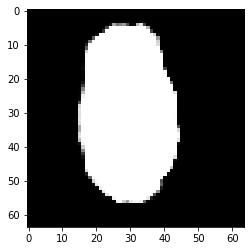

In [ ]:
model.eval()
p = model(x)[0]
plt.imshow(p.detach().squeeze(), cmap='gray')

# Model Evaluation

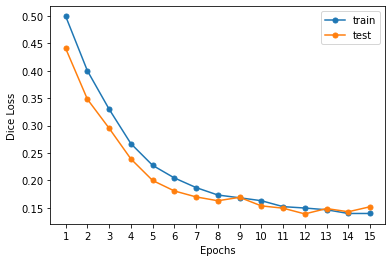

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X = np.arange(1,EPOCHS+1)

plt.plot(X, TRAIN_LOSS, marker='.', markersize=10, label='train')
plt.plot(X, TEST_LOSS, marker='.', markersize=10, label='test')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.xticks(X)
plt.legend()
plt.show()

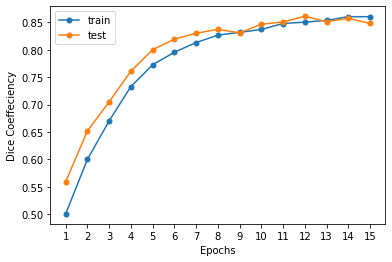

In [ ]:
plt.plot(X, TRAIN_DICE, marker='.', markersize=10, label='train')
plt.plot(X, TEST_DICE, marker='.', markersize=10, label='test')
plt.xlabel('Epochs')
plt.ylabel('Dice Coeffeciency')
plt.xticks(X)
plt.legend()
plt.show()

In [14]:
for batch in test_loader:
  x, y = batch
  print(x.shape, y.shape)
  break

torch.Size([64, 3, 128, 128]) torch.Size([64, 1, 128, 128])


In [ ]:
#load model
new_model = ImprovedUnet(feature_size=feature_size)

filename = "Unet_ISIC2.pth"
checkpoint = torch.load(filename)

new_model.load_state_dict(checkpoint)

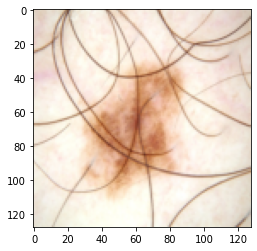

In [17]:
plt.imshow(x[0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


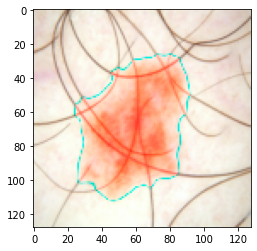

In [ ]:
alpha = 5
seg_img = x[0].clone()
image_r = seg_img[0]
image_r = image_r*(1-alpha*pred_mask)+(pred_mask*pred_mask*alpha)
segment_image = image_r.detach().squeeze()
seg_img[0] = segment_image
plt.imshow(seg_img.permute(1,2,0))